In [1]:
import os
from pathlib import Path
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
import torchvision
from torchvision import transforms
from torchmetrics import FBetaScore
from sklearn.metrics import classification_report
from modular import data_setup,engine,model_builder,utils
import random
from timeit import default_timer as timer
from tqdm.auto import tqdm

c:\Users\emirh\anaconda3\envs\wbottle\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_path = Path("data/")
data_path.mkdir(parents=True,exist_ok=True)

In [13]:
with zipfile.ZipFile("water_bottle_level.zip") as z:
  z.extractall(data_path)

In [4]:
image_list = []

for dirpath, dirnames, filenames in os.walk(data_path):
    for filename in filenames:
        if filename.endswith(".jpeg") or filename.endswith(".jpg"):
            image_list.append({"path": dirpath+os.sep+filename, "classes": os.path.basename(dirpath)})

df = pd.DataFrame(image_list)

In [5]:
df.head()

,path,classes
0,data\Full Water level\Full Water level\-on-w...,Full Water level
1,data\Full Water level\Full Water level\01-wa...,Full Water level
2,data\Full Water level\Full Water level\0bnC0...,Full Water level
3,data\Full Water level\Full Water level\1-0l-...,Full Water level
4,data\Full Water level\Full Water level\1000_...,Full Water level


In [6]:
df.shape

(429, 2)

In [7]:
df.classes.value_counts()

Full  Water level    255
Half water level     135
Overflowing           39
Name: classes, dtype: int64

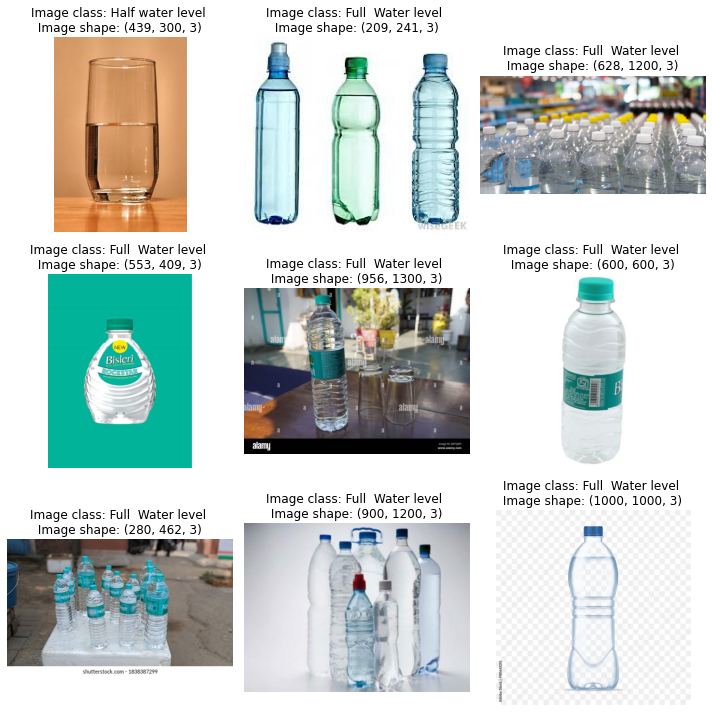

In [8]:
def plot_image(data):

    rnd_sample = df.sample(9)

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for ax, path in zip(axes, rnd_sample["path"]):
        img_class = rnd_sample[rnd_sample["path"] == path]["classes"].iloc[0]

        img = Image.open(path)
        img_as_array = np.array(img)
        ax.imshow(img_as_array)
        ax.set_title(f"Image class: {img_class} \n Image shape: {img_as_array.shape} ")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


plot_image(df)

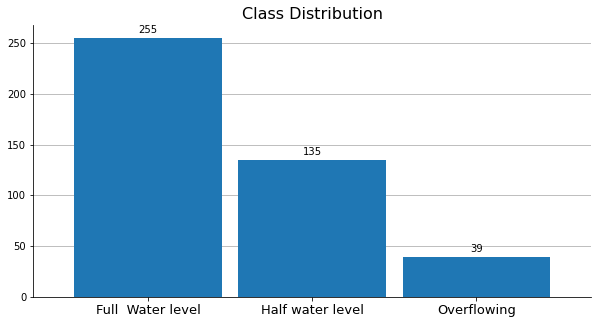

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
counts = df.classes.value_counts()
counts.plot.bar(width=0.9, rot=0, ax=ax)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(which="both", axis="y")
ax.set_axisbelow(True)

ax.set_title("Class Distribution", fontsize=16)
ax.tick_params(axis="x", labelsize=13)
for pos, value in enumerate(counts):
    ax.text(pos, value + 5, f"{value}", ha="center")


#### We have imbalanced label.

In [17]:
full_data_directory = "data/Full  Water level"
half_data_directory = "data/Half water level"
overflowing_data_directory = "data/Overflowing"

In [18]:
data_setup.augment_dataset(class_dir=full_data_directory, number_of_image=500)
data_setup.augment_dataset(class_dir=half_data_directory, number_of_image=500)
data_setup.augment_dataset(class_dir=overflowing_data_directory, number_of_image=500)

c:\Users\emirh\anaconda3\envs\wbottle\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [19]:
image_list = []

for dirpath, dirnames, filenames in os.walk(data_path):
    for filename in filenames:
        if filename.endswith(".jpeg") or filename.endswith(".jpg"):
            image_list.append({"path": dirpath+os.sep+filename, "classes": os.path.basename(dirpath)})

df_ = pd.DataFrame(image_list)

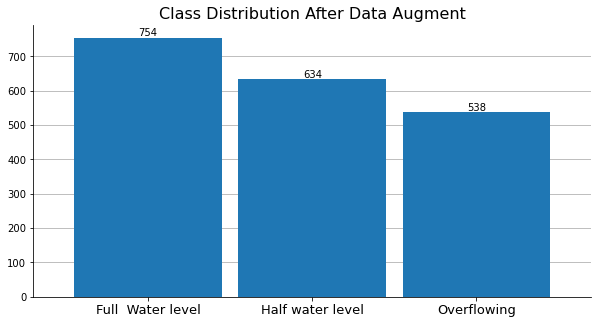

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
counts = df_.classes.value_counts()
counts.plot.bar(width=0.9, rot=0, ax=ax)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(which="both", axis="y")
ax.set_axisbelow(True)

ax.set_title("Class Distribution After Data Augment", fontsize=16)
ax.tick_params(axis="x", labelsize=13)
for pos, value in enumerate(counts):
    ax.text(pos, value + 5, f"{value}", ha="center")

### Random image in train dataset

In [24]:
model, data_transform = model_builder.create_model(model_name="EfficientNet_B0", num_classes=3)

In [27]:
train_df, test_df = data_setup.create_dataframe(data_path=data_path)
train_data_transformed = data_setup.CustomImageFolder(train_df,transform=data_transform)
test_data_transformed = data_setup.CustomImageFolder(test_df,transform=data_transform)

In [28]:
class_names=train_data_transformed.classes

In [29]:
def visualize_random_images(data, classes, num_images=3):
    random_samples_idx = random.sample(range(len(data)), k=num_images)
    plt.figure(figsize=(10, 10))
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = (
            data[targ_sample][0],
            data[targ_sample][1],
        )
        targ_image_adjust = targ_image.permute(1, 2, 0)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")

        title = f"class: {classes[targ_label]}"

        title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


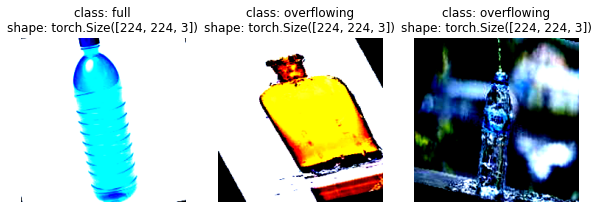

In [30]:
visualize_random_images(train_data_transformed,class_names)

In [24]:
untransform= transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
    
])

In [25]:
test_data_untransformed = CustomImageFolder(test_df, transform=untransform)

In [35]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_df,
    test_dir=test_df,
    transform=data_transform,
    batch_size=32,
)

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [38]:
fbeta_score = FBetaScore(task="multiclass", num_classes=len(class_names), beta=0.5).to(
    device
)

In [41]:
def create_writer(
    experiment_name=f"500_data",
    loss_fn=f"CrossEntropyLoss_fn",
    model_name=f"EfficientNet_B0",
    epoch=f"50_epochs",
    lr=f"1e-4_lr",
) -> torch.utils.tensorboard.writer.SummaryWriter:
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        epoch (str): Epoch number.
        lr (str): Learning rate used in the experiment.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter: Instance of a writer saving to log_dir.


    """
    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime(
        "%d-%m-%Y,%H-%M-%S"
    )  # returns current date in DD-MM-YYYY,H-M-S format

    log_dir_parts = ["runs", timestamp, experiment_name, model_name, loss_fn, epoch, lr]

    # Create log directory path
    log_dir = os.path.join(*log_dir_parts)
    print(log_dir)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [45]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

In [46]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
# Start the timer
start_time = timer()

# Starting training
results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=cross_entropy_loss,
    epochs=50,
    fbeta_score=fbeta_score,
    device=device,
    writer=create_writer(),
)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")
print("-" * 50 + "\n")

runs\11-08-2023,17-49-53\500_data\EfficientNet_B0\CrossEntropyLoss_fn\50_epochs\1e-4_lr
[INFO] Created SummaryWriter, saving to: runs\11-08-2023,17-49-53\500_data\EfficientNet_B0\CrossEntropyLoss_fn\50_epochs\1e-4_lr...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 
 train_loss: 1.0515 | train_f0.5_score: 47.0% | 
 test_loss: 0.9891 | test_f0.5_score: 65.0% | 


  2%|▏         | 1/50 [02:19<1:53:49, 139.37s/it]

Epoch: 2 
 train_loss: 0.9408 | train_f0.5_score: 64.0% | 
 test_loss: 0.8894 | test_f0.5_score: 75.0% | 


  4%|▍         | 2/50 [03:55<1:31:17, 114.11s/it]

Epoch: 3 
 train_loss: 0.8642 | train_f0.5_score: 73.0% | 
 test_loss: 0.8193 | test_f0.5_score: 75.0% | 


  6%|▌         | 3/50 [05:34<1:23:42, 106.86s/it]

Epoch: 4 
 train_loss: 0.7928 | train_f0.5_score: 76.0% | 
 test_loss: 0.7609 | test_f0.5_score: 78.0% | 


  8%|▊         | 4/50 [07:11<1:18:58, 103.00s/it]

Epoch: 5 
 train_loss: 0.7380 | train_f0.5_score: 78.0% | 
 test_loss: 0.7068 | test_f0.5_score: 78.0% | 


 10%|█         | 5/50 [08:43<1:14:20, 99.11s/it] 

Epoch: 6 
 train_loss: 0.6929 | train_f0.5_score: 80.0% | 
 test_loss: 0.6669 | test_f0.5_score: 79.0% | 


 12%|█▏        | 6/50 [10:24<1:13:04, 99.65s/it]

Epoch: 7 
 train_loss: 0.6628 | train_f0.5_score: 81.0% | 
 test_loss: 0.6410 | test_f0.5_score: 83.0% | 


 14%|█▍        | 7/50 [12:10<1:13:01, 101.90s/it]

Epoch: 8 
 train_loss: 0.6376 | train_f0.5_score: 80.0% | 
 test_loss: 0.6084 | test_f0.5_score: 84.0% | 


 16%|█▌        | 8/50 [13:50<1:10:55, 101.33s/it]

Epoch: 9 
 train_loss: 0.6096 | train_f0.5_score: 82.0% | 
 test_loss: 0.5781 | test_f0.5_score: 85.0% | 


 18%|█▊        | 9/50 [15:40<1:10:59, 103.89s/it]

Epoch: 10 
 train_loss: 0.5840 | train_f0.5_score: 83.0% | 
 test_loss: 0.5534 | test_f0.5_score: 85.0% | 


 20%|██        | 10/50 [17:27<1:10:01, 105.05s/it]

Epoch: 11 
 train_loss: 0.5564 | train_f0.5_score: 83.0% | 
 test_loss: 0.5438 | test_f0.5_score: 85.0% | 


 22%|██▏       | 11/50 [19:18<1:09:22, 106.73s/it]

Epoch: 12 
 train_loss: 0.5407 | train_f0.5_score: 85.0% | 
 test_loss: 0.5220 | test_f0.5_score: 84.0% | 


 24%|██▍       | 12/50 [21:09<1:08:25, 108.05s/it]

Epoch: 13 
 train_loss: 0.5354 | train_f0.5_score: 84.0% | 
 test_loss: 0.5038 | test_f0.5_score: 86.0% | 


 26%|██▌       | 13/50 [22:55<1:06:11, 107.33s/it]

Epoch: 14 
 train_loss: 0.5192 | train_f0.5_score: 83.0% | 
 test_loss: 0.4920 | test_f0.5_score: 86.0% | 


 28%|██▊       | 14/50 [25:10<1:09:25, 115.71s/it]

Epoch: 15 
 train_loss: 0.4918 | train_f0.5_score: 86.0% | 
 test_loss: 0.4811 | test_f0.5_score: 86.0% | 


 30%|███       | 15/50 [26:49<1:04:38, 110.82s/it]

Epoch: 16 
 train_loss: 0.4856 | train_f0.5_score: 85.0% | 
 test_loss: 0.4665 | test_f0.5_score: 87.0% | 


 32%|███▏      | 16/50 [28:15<58:34, 103.38s/it]  

Epoch: 17 
 train_loss: 0.4755 | train_f0.5_score: 85.0% | 
 test_loss: 0.4516 | test_f0.5_score: 86.0% | 


 34%|███▍      | 17/50 [29:45<54:35, 99.26s/it] 

Epoch: 18 
 train_loss: 0.4800 | train_f0.5_score: 86.0% | 
 test_loss: 0.4506 | test_f0.5_score: 87.0% | 


 36%|███▌      | 18/50 [31:22<52:30, 98.46s/it]

Epoch: 19 
 train_loss: 0.4515 | train_f0.5_score: 87.0% | 
 test_loss: 0.4412 | test_f0.5_score: 88.0% | 


 38%|███▊      | 19/50 [32:58<50:36, 97.96s/it]

Epoch: 20 
 train_loss: 0.4551 | train_f0.5_score: 87.0% | 
 test_loss: 0.4357 | test_f0.5_score: 87.0% | 


 40%|████      | 20/50 [34:37<49:02, 98.08s/it]

Epoch: 21 
 train_loss: 0.4367 | train_f0.5_score: 87.0% | 
 test_loss: 0.4205 | test_f0.5_score: 86.0% | 


 42%|████▏     | 21/50 [36:00<45:14, 93.60s/it]

Epoch: 22 
 train_loss: 0.4502 | train_f0.5_score: 86.0% | 
 test_loss: 0.4230 | test_f0.5_score: 88.0% | 


 44%|████▍     | 22/50 [37:33<43:38, 93.53s/it]

Epoch: 23 
 train_loss: 0.4386 | train_f0.5_score: 86.0% | 
 test_loss: 0.4060 | test_f0.5_score: 88.0% | 


 46%|████▌     | 23/50 [39:12<42:45, 95.02s/it]

Epoch: 24 
 train_loss: 0.4216 | train_f0.5_score: 86.0% | 
 test_loss: 0.4019 | test_f0.5_score: 88.0% | 


 48%|████▊     | 24/50 [41:03<43:14, 99.77s/it]

Epoch: 25 
 train_loss: 0.4191 | train_f0.5_score: 86.0% | 
 test_loss: 0.3945 | test_f0.5_score: 88.0% | 


 50%|█████     | 25/50 [42:55<43:09, 103.58s/it]

Epoch: 26 
 train_loss: 0.4163 | train_f0.5_score: 87.0% | 
 test_loss: 0.3819 | test_f0.5_score: 89.0% | 


 52%|█████▏    | 26/50 [44:40<41:35, 103.99s/it]

Epoch: 27 
 train_loss: 0.4048 | train_f0.5_score: 87.0% | 
 test_loss: 0.3749 | test_f0.5_score: 89.0% | 


 54%|█████▍    | 27/50 [46:45<42:16, 110.28s/it]

Epoch: 28 
 train_loss: 0.4066 | train_f0.5_score: 87.0% | 
 test_loss: 0.3753 | test_f0.5_score: 88.0% | 


 56%|█████▌    | 28/50 [48:50<42:02, 114.66s/it]

Epoch: 29 
 train_loss: 0.3878 | train_f0.5_score: 88.0% | 
 test_loss: 0.3677 | test_f0.5_score: 89.0% | 


 58%|█████▊    | 29/50 [50:06<36:06, 103.18s/it]

Epoch: 30 
 train_loss: 0.4047 | train_f0.5_score: 86.0% | 
 test_loss: 0.3608 | test_f0.5_score: 89.0% | 


 60%|██████    | 30/50 [51:23<31:42, 95.13s/it] 

Epoch: 31 
 train_loss: 0.3840 | train_f0.5_score: 89.0% | 
 test_loss: 0.3579 | test_f0.5_score: 89.0% | 


 62%|██████▏   | 31/50 [52:41<28:31, 90.10s/it]

Epoch: 32 
 train_loss: 0.3880 | train_f0.5_score: 88.0% | 
 test_loss: 0.3585 | test_f0.5_score: 89.0% | 


 64%|██████▍   | 32/50 [53:58<25:53, 86.33s/it]

Epoch: 33 
 train_loss: 0.3718 | train_f0.5_score: 89.0% | 
 test_loss: 0.3509 | test_f0.5_score: 89.0% | 


 66%|██████▌   | 33/50 [55:16<23:40, 83.58s/it]

Epoch: 34 
 train_loss: 0.3704 | train_f0.5_score: 88.0% | 
 test_loss: 0.3497 | test_f0.5_score: 89.0% | 


 68%|██████▊   | 34/50 [56:33<21:47, 81.71s/it]

Epoch: 35 
 train_loss: 0.3602 | train_f0.5_score: 89.0% | 
 test_loss: 0.3410 | test_f0.5_score: 90.0% | 


 70%|███████   | 35/50 [57:50<20:03, 80.26s/it]

Epoch: 36 
 train_loss: 0.3782 | train_f0.5_score: 88.0% | 
 test_loss: 0.3406 | test_f0.5_score: 89.0% | 


 72%|███████▏  | 36/50 [59:07<18:32, 79.44s/it]

Epoch: 37 
 train_loss: 0.3607 | train_f0.5_score: 89.0% | 
 test_loss: 0.3285 | test_f0.5_score: 90.0% | 


 74%|███████▍  | 37/50 [1:00:24<17:03, 78.71s/it]

Epoch: 38 
 train_loss: 0.3559 | train_f0.5_score: 89.0% | 
 test_loss: 0.3323 | test_f0.5_score: 90.0% | 


 76%|███████▌  | 38/50 [1:01:42<15:39, 78.26s/it]

Epoch: 39 
 train_loss: 0.3507 | train_f0.5_score: 89.0% | 
 test_loss: 0.3280 | test_f0.5_score: 90.0% | 


 78%|███████▊  | 39/50 [1:02:59<14:18, 78.05s/it]

Epoch: 40 
 train_loss: 0.3709 | train_f0.5_score: 88.0% | 
 test_loss: 0.3227 | test_f0.5_score: 90.0% | 


 80%|████████  | 40/50 [1:04:17<13:00, 78.09s/it]

Epoch: 41 
 train_loss: 0.3415 | train_f0.5_score: 89.0% | 
 test_loss: 0.3149 | test_f0.5_score: 90.0% | 


 82%|████████▏ | 41/50 [1:05:35<11:41, 77.95s/it]

Epoch: 42 
 train_loss: 0.3444 | train_f0.5_score: 89.0% | 
 test_loss: 0.3140 | test_f0.5_score: 90.0% | 


 84%|████████▍ | 42/50 [1:06:52<10:22, 77.81s/it]

Epoch: 43 
 train_loss: 0.3374 | train_f0.5_score: 90.0% | 
 test_loss: 0.3077 | test_f0.5_score: 91.0% | 


 86%|████████▌ | 43/50 [1:08:10<09:04, 77.77s/it]

Epoch: 44 
 train_loss: 0.3672 | train_f0.5_score: 87.0% | 
 test_loss: 0.3134 | test_f0.5_score: 92.0% | 


 88%|████████▊ | 44/50 [1:09:29<07:47, 77.98s/it]

Epoch: 45 
 train_loss: 0.3359 | train_f0.5_score: 90.0% | 
 test_loss: 0.3081 | test_f0.5_score: 90.0% | 


 90%|█████████ | 45/50 [1:10:48<06:32, 78.42s/it]

Epoch: 46 
 train_loss: 0.3320 | train_f0.5_score: 89.0% | 
 test_loss: 0.2974 | test_f0.5_score: 92.0% | 


 92%|█████████▏| 46/50 [1:12:06<05:12, 78.19s/it]

Epoch: 47 
 train_loss: 0.3345 | train_f0.5_score: 89.0% | 
 test_loss: 0.2933 | test_f0.5_score: 91.0% | 


 94%|█████████▍| 47/50 [1:13:43<04:11, 83.84s/it]

Epoch: 48 
 train_loss: 0.3299 | train_f0.5_score: 89.0% | 
 test_loss: 0.3011 | test_f0.5_score: 91.0% | 


 96%|█████████▌| 48/50 [1:15:31<03:02, 91.09s/it]

Epoch: 49 
 train_loss: 0.3330 | train_f0.5_score: 89.0% | 
 test_loss: 0.2985 | test_f0.5_score: 91.0% | 


 98%|█████████▊| 49/50 [1:16:59<01:30, 90.31s/it]

Epoch: 50 
 train_loss: 0.3304 | train_f0.5_score: 89.0% | 
 test_loss: 0.2866 | test_f0.5_score: 91.0% | 


100%|██████████| 50/50 [1:18:26<00:00, 94.12s/it]

[INFO] Total training time: 4706.135 seconds
--------------------------------------------------



In [51]:
def plot_curves(results):
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]
    train_acc = results["train_fbeta_score"]
    test_acc = results["test_fbeta_score"]
    epochs = range(len(train_loss))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle("Comparison of Training and Testing Metrics Over Epochs", fontsize=16)

    metric_names = [("loss", "Loss"), ("fbeta_score", "f0.5")]
    for ax, (metric, label) in zip(axes, metric_names):
        ax.plot(epochs, results[f"train_{metric}"], label=f"train {label}")
        ax.plot(epochs, results[f"test_{metric}"], label=f"test {label}")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(which="both", axis="y")
        ax.set_axisbelow(True)
        ax.set_xlabel("Epochs")
        ax.set_title(label)
        ax.legend()

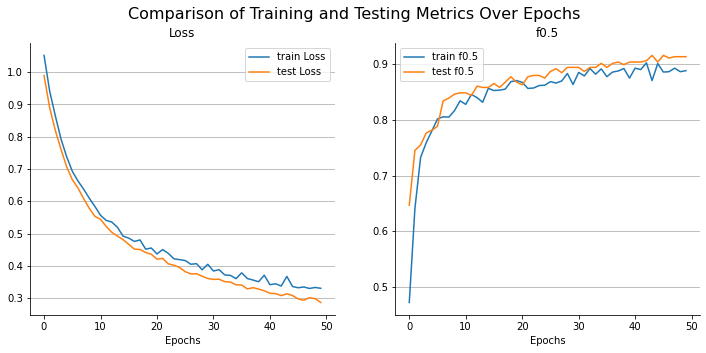

In [52]:
plot_curves(results)

In [53]:
from tqdm.auto import tqdm
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    y_logit = model(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)

100%|██████████| 13/13 [00:14<00:00,  1.11s/it]


In [54]:
targets=test_data_transformed.targets
mapping = {'full': 0, 'half': 1, 'overflowing': 2}
targets = np.array([mapping[i] for i in targets])

In [55]:
from sklearn.metrics import classification_report

In [56]:
clf_report = classification_report(targets, y_pred_tensor.cpu().numpy(), 
        target_names=class_names)
print(clf_report)

              precision    recall  f1-score   support

        full       0.90      0.87      0.89       151
        half       0.88      0.88      0.88       127
 overflowing       0.94      0.99      0.96       108

    accuracy                           0.91       386
   macro avg       0.91      0.91      0.91       386
weighted avg       0.91      0.91      0.91       386



Text(0.5, 1.0, 'Confusion Matrix')

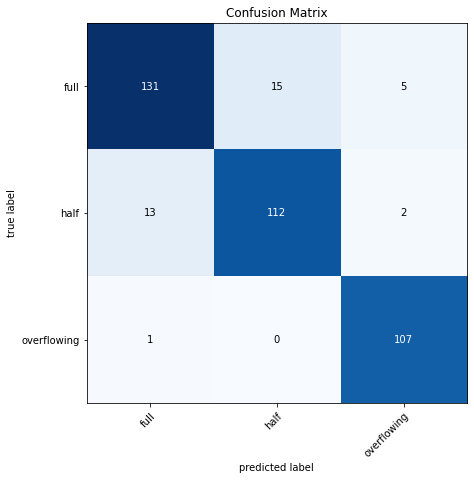

In [57]:
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix


confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,target=torch.from_numpy(targets).type(torch.float)
                         )

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names, #
    figsize=(10, 7))
ax.set_title("Confusion Matrix")

In [59]:
import torchvision

In [60]:
from typing import List, Tuple
def pred_and_plot_image(model: torch.nn.Module,
                        image_path : str,
                        class_names: List[str],
                        image_size: Tuple[int,int]=(224,224),
                        transform: torchvision.transforms=None,
                        device: torch.device=device):
    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = torchvision.transforms.Compose([transforms.Resize(image_size),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize(mean=[0.485,0.456,0.406],
                                                                               std=[0.229,0.224,0.225]) ])

    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0).to(device)
        
        target_image_pred = model(transformed_image).to(device)
    target_image_pred_prob = torch.softmax(target_image_pred,dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_prob,dim=1)
    
    
    plt.figure()
    plt.imshow(img)
    plt.title(f"pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_prob.max():.3f}")
    plt.axis(False)

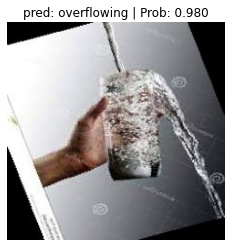

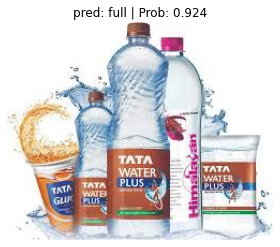

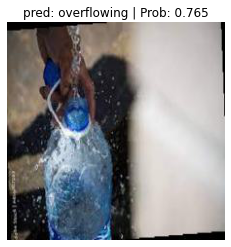

In [61]:
import random
num_images_to_plot=3
test_image_path_list = list(test_df["path"])
test_image_path_sample = random.sample(population=test_image_path_list,k=num_images_to_plot)
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,image_path=image_path,class_names=class_names,image_size=(224,224),device=device)
    